### Import Dependencies

In [ ]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import os
import sys
import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import PIL
from PIL import Image
from collections import OrderedDict

import torch 
from torch import nn, optim 
from torch.optim import lr_scheduler 
from torch.autograd import Variable
import torchvision 
from torchvision import datasets, models, transforms 
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

### Check GPU (in case you are not running this locally)

In [ ]:
# CHECK IF GPU IS WORKING

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:    
  print('Training on CPU ...')
else:    
  print('You are good to go!  Training on GPU ...')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Training on CPU ...


### Mapping the Data
First, map the data to the labels(skintone categories). The dataset comes with a JSON file that contains this mapping. We will just have to load it.

In [ ]:
with open('./content/skin.json', 'r') as f:
    cat_to_name = json.load(f)
cat_to_name

{'0': 'dark skin', '2': 'porcelain skin', '1': 'olive skin'}

### Load and use model for image classification and prediction

In [ ]:
ckpt = torch.load('checkpoint_ic_d161.pth')
ckpt.keys()

dict_keys(['input_size', 'output_size', 'epochs', 'batch_size', 'model', 'classifier', 'scheduler', 'optimizer', 'state_dict', 'class_to_idx'])

In [ ]:
image_size = 224
# Values used for normalizing the images. Default here are for pretrained models from torchvision.
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

In [ ]:
def load_checkpoint(filepath):
    """Load pre-trained model from the checkpoint."""
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
    # checkpoint['input_size'] = 25088
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.load_state_dict = (checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = checkpoint['optimizer']
    epochs = checkpoint['epochs']

    for param in model.parameters():
        param.requires_grad = False

    return model, checkpoint['class_to_idx']


model, class_to_idx = load_checkpoint('./models/checkpoint_ic_d161.pth')


In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array.
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image


def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


In [ ]:
import numpy as np
import torch

def tensor_to_image(tensor):
    """Convert the tensor output from 'process_image' to a numpy array."""
    tensor = tensor.cpu().detach().numpy()
    
    # Scale the values to [0, 255]
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    tensor = 255 * tensor
    
    # Convert the numpy array to an image array
    image_array = tensor.transpose((1, 2, 0)).astype(np.uint8)
    
    return image_array


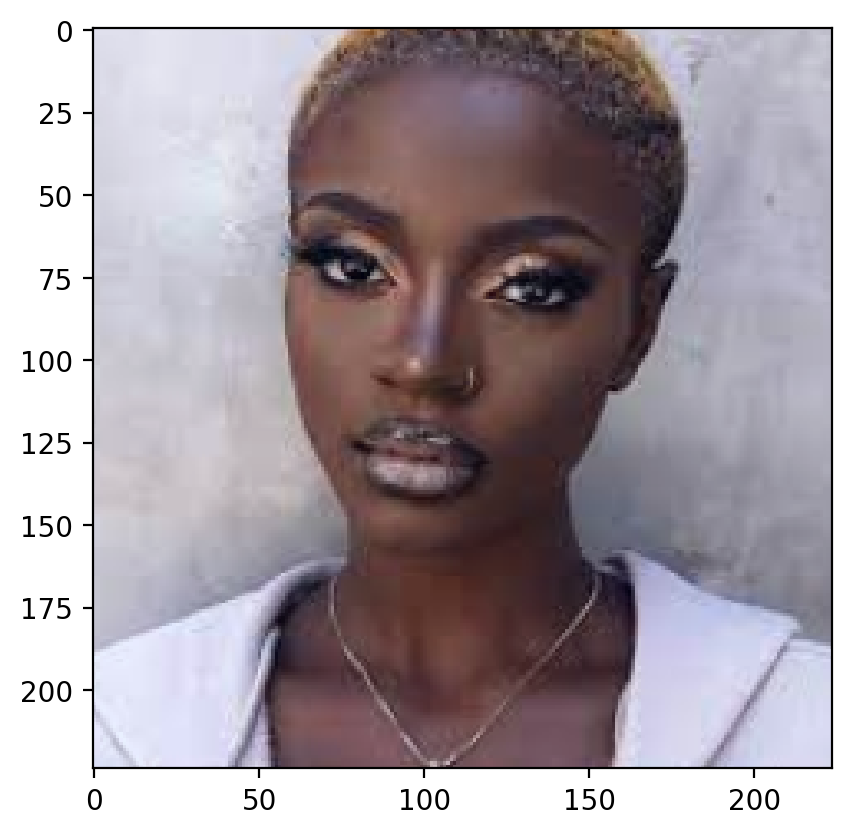

In [ ]:
# Testing imshow function
with Image.open('./content/valid/darkskin/images.jpg') as image:
    processed_image = process_image(image)
    pil_image = tensor_to_image(processed_image)
    plt.imshow(pil_image)

In [ ]:
def predict(image_path, model, topk=3):
    ''' Predict the class (or classes) of an image using a trained deep learning model.'''

    # Implement the code to predict the class from an image file
    img = Image.open(image_path)
    img = process_image(img)
    # print("HIIIII")
    # Convert 2D image to 1D vectorcle
    img = np.expand_dims(img, 0)

    img = torch.from_numpy(img)

    model.eval()
    inputs = Variable(img).to(device)
    # print(inputs)
    # model.classifier[0] = nn.Linear(2208, 120, bias = True)

    logits = model.forward(inputs)

    ps = F.softmax(logits, dim=1)
    topk = ps.cpu().topk(topk)

    return (e.data.numpy().squeeze().tolist() for e in topk)



In [ ]:
import plotly.graph_objects as go
import pandas as pd

# load the makeup dataset
rec = pd.read_csv('./content/makeup.csv')

def view_classify(img_path, prob, classes, cat_to_name, rec):
    ''' 
        Function for viewing an image, probability of it belonging to the classes.
        Also display recommended products based on class with highest probability
    '''
    image = Image.open(img_path)
    prob, classes = predict(img_path, model.to(device))
    # nd = {'darkskin': 1, 'olive skin': 2, 'porcelain skin': 3}

    # Show the image being classified
    fig, (ax1, ax2) = plt.subplots(figsize=(13, 5), ncols=2)
    ax1.set_title('Uploaded Image')
    ax1.imshow(image)
    ax1.axis('off')
    print(f"Classes: {classes}")

    # Show the prediction probability outputted by model for the image
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(classes)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Skintone Class Probability')

    # Set spacing between subplots
    plt.subplots_adjust(wspace=0.5)
    plt.show()

    # Select products equivalent to skintone of uploaded image
    skintype = cat_to_name[str(classes[0])]
    rec1 = rec.loc[rec['SkinTone'] == skintype][:3]

    # Display recommended products based on the model's predictions in tabular format
    fig = go.Figure(data=[go.Table(
    header=dict(values=list(rec1.columns),
               fill_color='paleturquoise',
               align='left'),
    cells=dict(values=[rec1.Foundation, rec1.HEXColor, rec1.SkinTone,rec1.Company, rec1.ProductURL, rec1.Price, rec1.Image, rec1.VideoTutorial],
              fill_color='lavender',
              align='left'))
      ])
    fig.update_layout(
        title={
            'text': "Product Recommendations",
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        }
    )
    fig.show()
    # print(rec1.to_dict())

    def make_clickable(val):
        # target _blank to open new window
        return '<a target="_blank" href="{}">{}</a>'.format(val, val)

    rec1.style.format({'ProductURL': make_clickable})

    return (rec1)


Classes: [2, 1, 0]


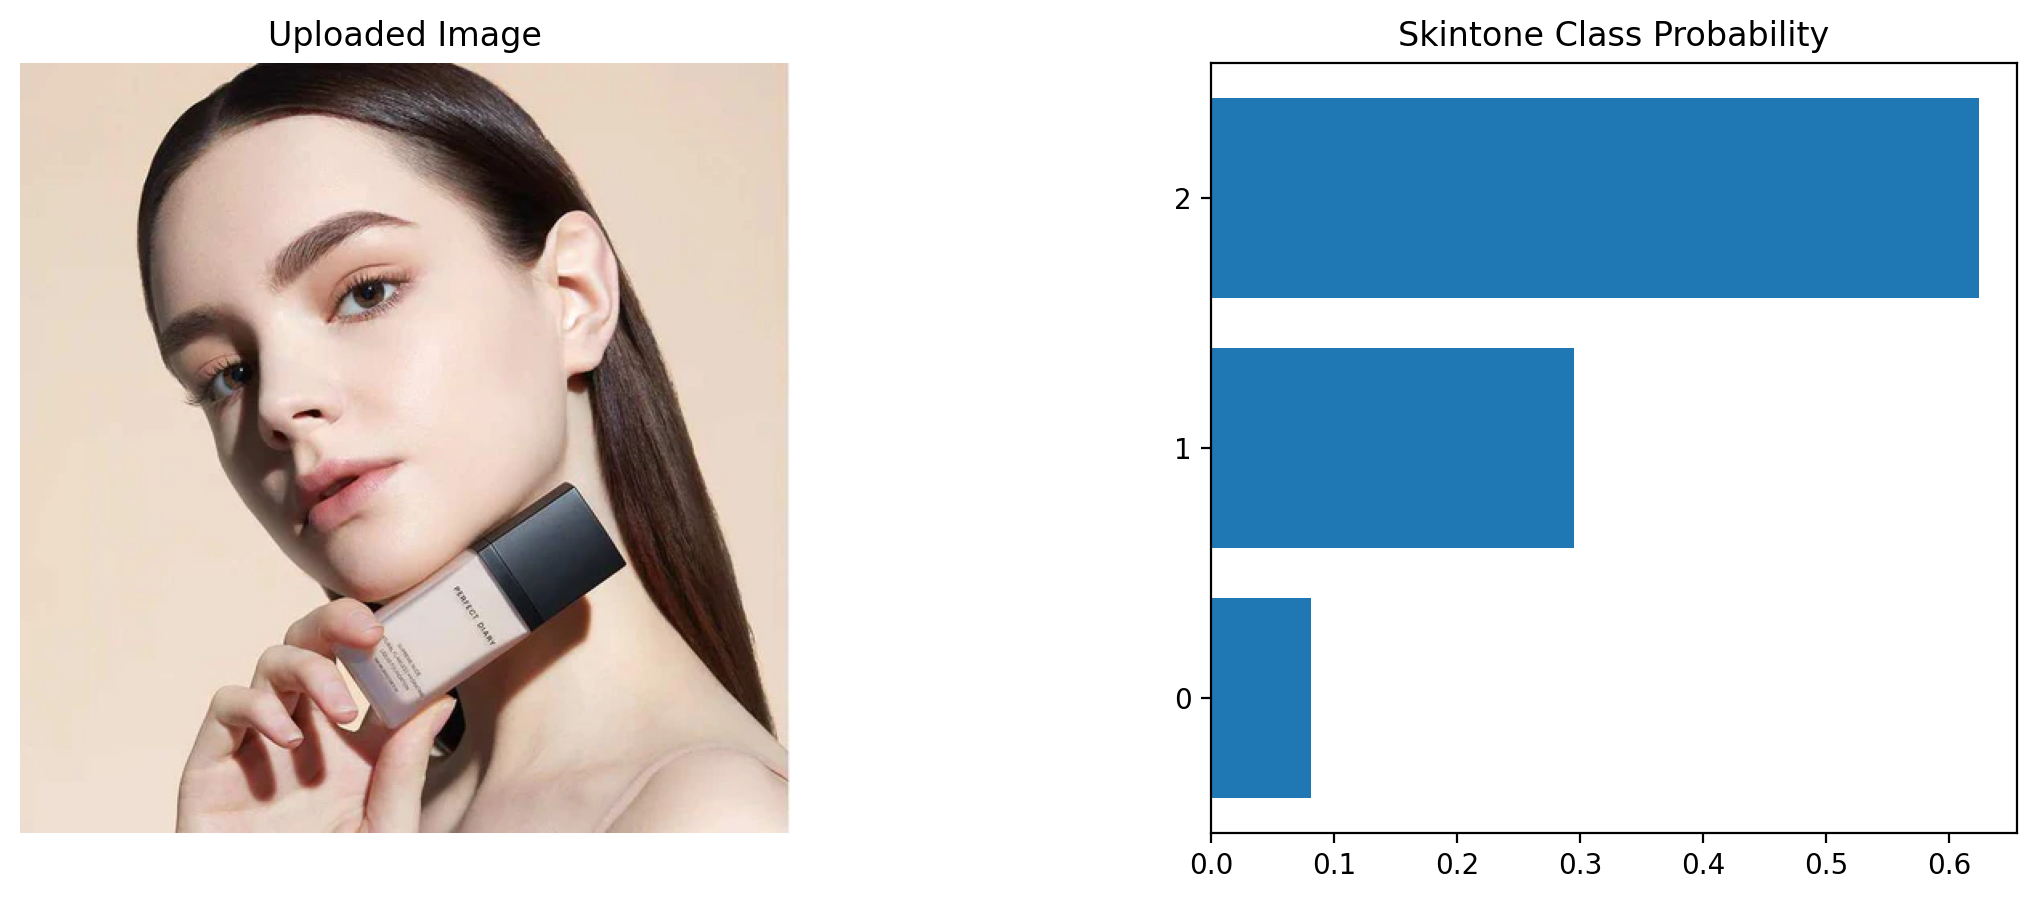

In [ ]:
file = './content/valid/porcelainskin/images.jpg'
probs, classes = predict(file, model.to(device))
text = (view_classify(file, probs, classes, cat_to_name, rec))

Classes: [0, 2, 1]


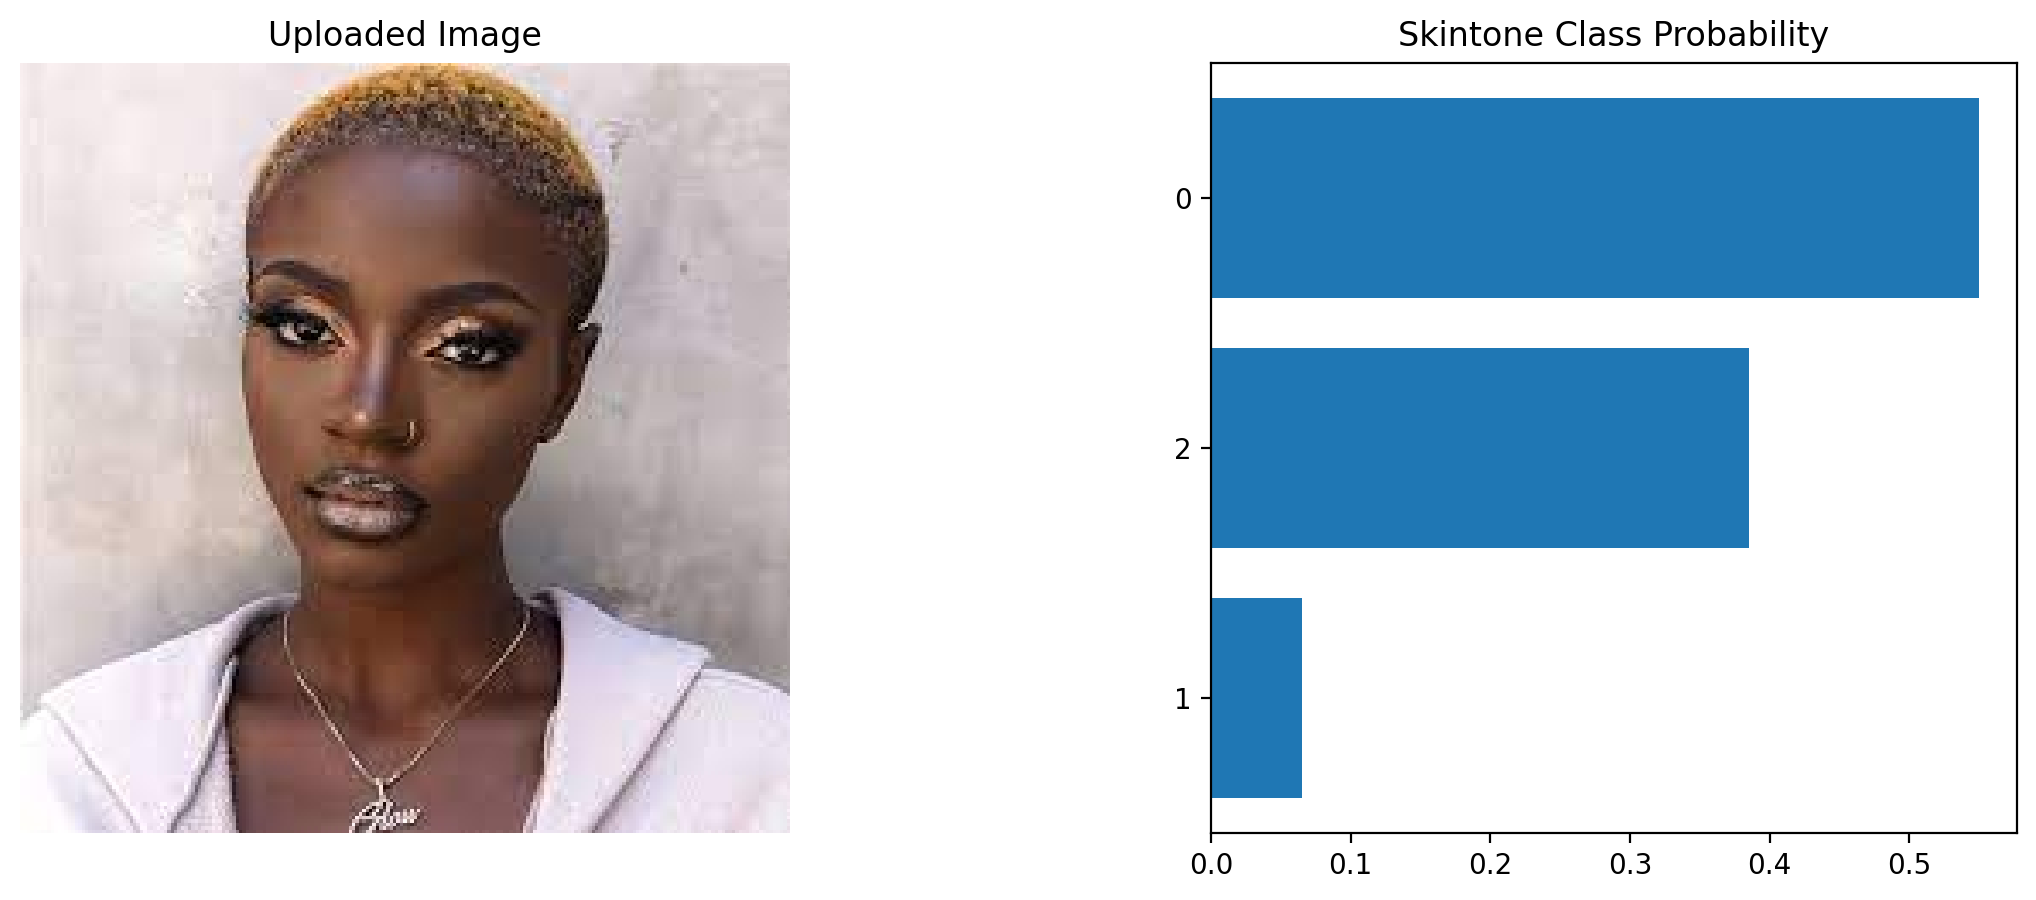

In [ ]:
file = './content/valid/darkskin/images.jpg'
probs, classes = predict(file, model.to(device))
text = (view_classify(file, probs, classes, cat_to_name, rec))

Classes: [1, 2, 0]


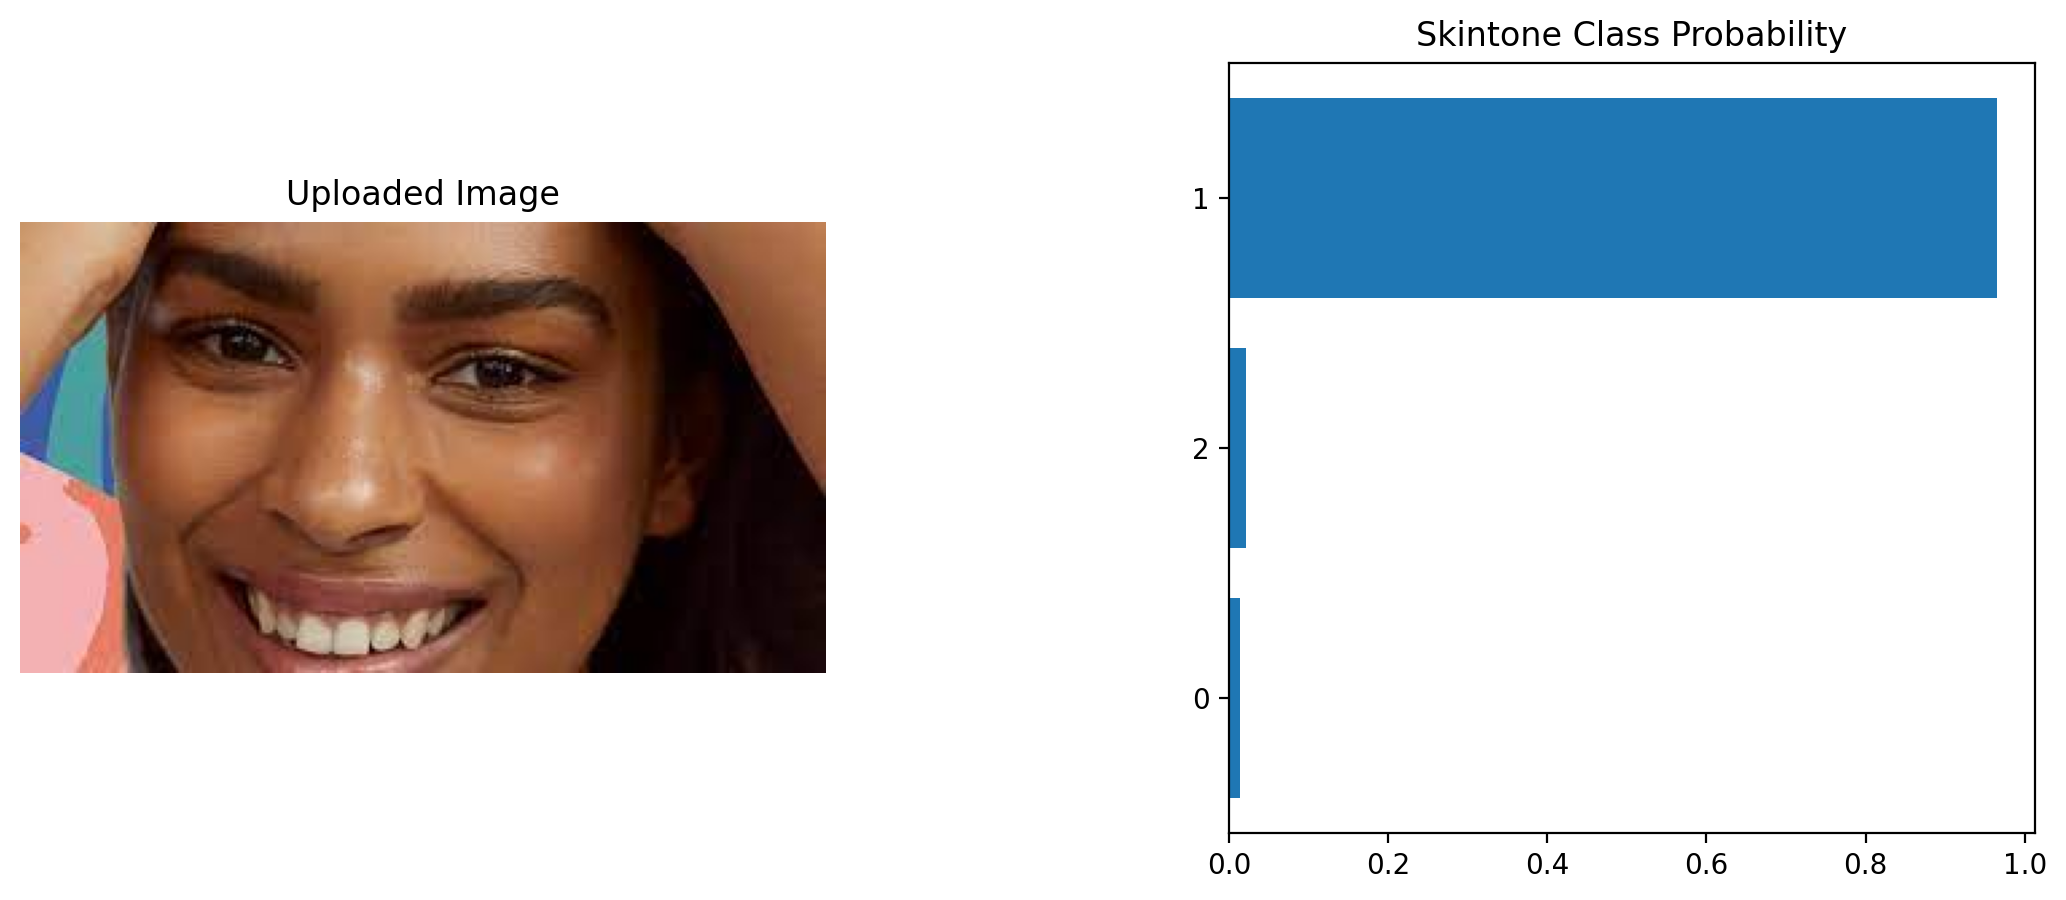

In [ ]:
file = './content/valid/oliveskin/3.olive.jpg'
probs, classes = predict(file, model.to(device))
text = (view_classify(file, probs, classes, cat_to_name, rec))

In [ ]:
# def predict(image_path, model, topk=5, device='cuda'):
#     ''' Predict the class (or classes) of an image using a trained deep learning model.
#     '''
#     model.eval()
    
#     # cpu mode
#     model.cpu()
    
#     # load image as torch.Tensor
#     image = process_image(image_path)
    
#     # Unsqueeze returns a new tensor with a dimension of size one
#     # https://pytorch.org/docs/stable/torch.html#torch.unsqueeze
#     image = image.unsqueeze(0)
    
#     # Disabling gradient calculation 
#     # (not needed with evaluation mode?)
#     with torch.no_grad():
#         output = model.forward(image)
#         top_prob, top_labels = torch.topk(output, topk)
        
#         # Calculate the exponentials
#         top_prob = top_prob.exp()
        
#     class_to_idx_inv = {model.class_to_idx[k]: k for k in model.class_to_idx}
#     mapped_classes = list()
    
#     for label in top_labels.numpy()[0]:
#         mapped_classes.append(class_to_idx_inv[label])
        
#     return top_prob.numpy()[0], mapped_classes

